In [1]:
import numpy as np
import torch
import pyro
import pyro.optim
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate
from torch.distributions import constraints
from pyro import distributions as dst
from collections import defaultdict
import matplotlib.pylab as plt

In [2]:
pyro.enable_validation(True)

In [3]:
N = 1000
D = 2
K = 2

In [6]:
# a factor model sans observation model and D-plate
# D-plate is inherited from parent, so everything is moved one level up
# returns parameters of factor model
initial_hyperparameters = (K,torch.randn(D),torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
def factorLatents(X, hyperparameters = initial_hyperparameters, name = ''):
    N, D = X.shape
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    #with pyro.plate('D_{}'.format(name), D):
    loc = pyro.sample('loc_{}'.format(name), dst.Normal(locloc, locscale))
    cov_diag = pyro.sample('scale_{}'.format(name), dst.LogNormal(scaleloc, scalescale))
    with pyro.plate('K_{}'.format(name), K):
        cov_factor = pyro.sample('cov_factor_{}'.format(name), dst.Normal(cov_factor_loc,cov_factor_scale))
    cov_factor = cov_factor.transpose(0,1)
    #with pyro.plate('N', N):
    #    X = pyro.sample('obs', dst.LowRankMultivariateNormal(loc, cov_factor=cov_factor, cov_diag=cov_diag))
    return loc, cov_factor, cov_diag

In [7]:
def mixtureOfFactor(X, hyperparameters):
    N, D = X.shape
    K = 2
    L = 2
    coord_scale_loc, coord_scale_scale, loc_loc, loc_scale, component_logits_concentration = hyperparameters
    component_logits = pyro.sample('component_logits', dst.Dirichlet(component_logits_concentration))
    locs = torch.empty((D,K))
    cov_factors = torch.empty((K,D,L))
    cov_diags = torch.empty((D,K))
    with pyro.plate('D', D):
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(coord_scale_loc,coord_scale_scale))
        for k in pyro.plate('K', K):
            factor_hyperparameters = (L,torch.randn(D),20*torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
            locs[k], cov_factors[k], cov_diags[k] = factorLatents(X, hyperparameters = factor_hyperparameters, name = 'factor_{}'.format(k))
    with pyro.plate('N', N):
        assignment = pyro.sample('assignment', dst.Categorical(component_logits), infer={"enumerate": "parallel"})
        #X = pyro.sample('obs', dst.MultivariateNormal(locs[assignment], torch.diag(coord_scale)))
        X = pyro.sample('obs', dst.LowRankMultivariateNormal(locs[assignment], cov_factors[assignment], cov_diags[assignment]))
    return X

In [8]:
hyperparameters = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2,10*torch.abs(torch.randn(K)))

In [9]:
trace = pyro.poutine.trace(mixtureOfFactor).get_trace(torch.zeros(N,D), hyperparameters)
logp = trace.log_prob_sum()
true_variables = [trace.nodes[name]["value"] for name in trace.stochastic_nodes]
trace.stochastic_nodes

['component_logits',
 'D',
 'coord_scale',
 'K',
 'loc_factor_0',
 'scale_factor_0',
 'K_factor_0',
 'cov_factor_factor_0',
 'loc_factor_1',
 'scale_factor_1',
 'K_factor_1',
 'cov_factor_factor_1',
 'N',
 'assignment',
 'obs']

In [10]:
true_variables

[tensor([0.5872, 0.4128]),
 tensor([0, 1]),
 tensor([1.9963, 9.4442]),
 tensor([0, 1]),
 tensor([-2.5408,  5.0855]),
 tensor([1.0562, 0.8707]),
 tensor([0, 1]),
 tensor([[-0.3207,  0.5225],
         [ 0.1879,  0.1140]]),
 tensor([-7.9274, -6.2547]),
 tensor([4.6443, 0.9166]),
 tensor([0, 1]),
 tensor([[ 0.0497, -0.0401],
         [-1.0981, -1.1829]]),
 tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
          14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
          28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
          42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
          56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
          70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
          84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
          98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
         112, 

In [11]:
logp

tensor(-4183.1191)

In [12]:
data = true_variables[-1]

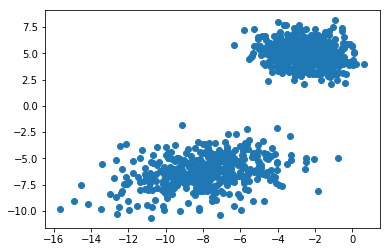

In [13]:
plt.scatter(*data.detach().numpy().T)

In [14]:
# a factor model sans observation model and D-plate
# D-plate is inherited from parent guide
# returns parameters of factor model
def factorLatentsGuide(X, hyperparameters, name = ''):
#def guide(X):
    #K = 2
    K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = hyperparameters
    #K, locloc, locscale, scaleloc, scalescale, cov_factor_loc, cov_factor_scale = (K,torch.zeros(D),torch.ones(D),torch.zeros(D),torch.ones(D),torch.zeros(K,D),torch.ones(K,D))
    #with pyro.plate('D', D, dim=-1):
    loc_loc = pyro.param('loc_loc_{}'.format(name), locloc)
    loc_scale = pyro.param('loc_scale_{}'.format(name), locscale, constraint=constraints.positive)
    cov_diag_loc = pyro.param('scale_loc_{}'.format(name), scaleloc)
    cov_diag_scale = pyro.param('scale_scale_{}'.format(name), scalescale, constraint=constraints.positive)
    # sample variables
    loc = pyro.sample('loc_{}'.format(name), dst.Normal(loc_loc,loc_scale))
    with pyro.plate('K_{}'.format(name), K):
        cov_factor_loc = pyro.param('cov_factor_loc_{}'.format(name), cov_factor_loc)
        cov_factor_scale = pyro.param('cov_factor_scale_{}'.format(name), cov_factor_scale, constraint=constraints.positive)
        cov_factor = pyro.sample('cov_factor_{}'.format(name), dst.Normal(cov_factor_loc, cov_factor_scale))
    cov_factor = cov_factor.transpose(0,1)
    cov_diag = pyro.sample('scale_{}'.format(name), dst.LogNormal(cov_diag_loc, cov_diag_scale))
    return loc, cov_factor, cov_diag

In [15]:
def mixtureOfFactorGuide(X, hyperparameters):
    N, D = X.shape
    K = 2
    L = 2
    coord_scale_loc, coord_scale_scale, loc_loc, loc_scale, component_logits_concentration = hyperparameters
    locs = torch.empty((D,K))
    cov_factors = torch.empty((K,D,L))
    cov_diags = torch.empty((D,K))
    with pyro.plate('D', D):
        coord_scale_loc = pyro.param('coord_scale_loc', coord_scale_loc)
        coord_scale_scale = pyro.param('coord_scale_scale', coord_scale_scale, constraint=constraints.positive)
        coord_scale = pyro.sample('coord_scale', dst.LogNormal(coord_scale_loc,coord_scale_scale))
        for k in pyro.plate('K', K):
            factor_hyperparameters = (L,torch.randn(D),10*torch.abs(torch.randn(D)),torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2)
            locs[k], cov_factors[k], cov_diags[k] = factorLatentsGuide(X, hyperparameters = factor_hyperparameters, name = 'factor_{}'.format(k))
    component_logits_concentration = pyro.param('component_logits_concentration', component_logits_concentration, constraint=constraints.positive)
    component_logits = pyro.sample('component_logits', dst.Dirichlet(component_logits_concentration))
    return coord_scale, locs, cov_factors, cov_diags, component_logits

In [16]:
track_params = True
def per_param_callable(module_name, param_name):
    #return {"lr": 0.01, "betas": (0.9, 0.8)} # too much momentum slows down learning apparently
    #return {"lr": 0.005, "betas": (0.9, 0.9)} # too much momentum slows down learning apparently
    return {"lr": 0.01, "betas": (0.90, 0.999)} # from http://pyro.ai/examples/svi_part_i.html
    #return {"lr": 0.001, 'betas': [0.9, 0.99]}
    #return {"lr": 0.01, 'betas': [0.9, 0.99]}
    #return {"lr": 0.1, 'betas': [0.9, 0.99]}

In [17]:
pyro.clear_param_store()

In [18]:
conditioned_model = pyro.condition(mixtureOfFactor, data = {'obs': data})
optim = torch.optim.Adam
scheduler = pyro.optim.ExponentialLR({'optimizer': optim, 'optim_args': per_param_callable, 'gamma': 0.99 })
elbo = TraceEnum_ELBO(max_plate_nesting=3)
svi = SVI(conditioned_model, mixtureOfFactorGuide, scheduler, loss=elbo, num_samples=50)

In [19]:
hyperparameters = (torch.randn(D),torch.abs(torch.randn(D)),torch.randn(K,D),torch.abs(torch.randn(K,D))*2,torch.abs(torch.randn(K)))

In [20]:
# Register hooks to monitor gradient norms.
losses = []
gradient_norms = defaultdict(list)
# take one svi step to populate the param store
loss = svi.step(data, hyperparameters)
#loss = svi.step(data, initial_hyperparameters)
if track_params:
    param_history = dict({k:v.unsqueeze(0) for k,v in pyro.get_param_store().items()})
# register gradient hooks for monitoring
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

In [21]:
# optimize
for i in range(15000):
    loss = svi.step(data, hyperparameters)
    if i % 100:
        print('.', end='')
    else:
        scheduler.step()
        state = scheduler.get_state()['component_logits_concentration']
        print('\nSetting lr to {}'.format(state['base_lrs'][0]*state['gamma']**state['last_epoch']), end='')
        print('\n', end='')
        print(i)
    #loss = svi.step(data, initial_hyperparameters)
    losses.append(loss)
    if track_params:
    # warning: this builds the param_history dict from scratch in every iteration
        param_history = {k:torch.cat([param_history[k],v.unsqueeze(0)],dim=0) for k,v in pyro.get_param_store().items()}
        #print('.' if i % 100 else '\n', end='')
params = pyro.get_param_store()


Setting lr to 0.0099
0
...................................................................................................
Setting lr to 0.009801
100
...................................................................................................
Setting lr to 0.00970299
200
...................................................................................................
Setting lr to 0.0096059601
300
...................................................................................................
Setting lr to 0.009509900499
400
...................................................................................................
Setting lr to 0.00941480149401
500
...................................................................................................
Setting lr to 0.0093206534790699
600
...................................................................................................
Setting lr to 0.0092274469442792
700
...............................................

...................................................................................................
Setting lr to 0.0054168507596685355
6000
...................................................................................................
Setting lr to 0.00536268225207185
6100
...................................................................................................
Setting lr to 0.005309055429551132
6200
...................................................................................................
Setting lr to 0.00525596487525562
6300
...................................................................................................
Setting lr to 0.005203405226503064
6400
...................................................................................................
Setting lr to 0.005151371174238033
6500
...................................................................................................
Setting lr to 0.005099857462495653
6600
.....................

...................................................................................................
Setting lr to 0.0030240443566902156
11800
...................................................................................................
Setting lr to 0.002993803913123313
11900
...................................................................................................
Setting lr to 0.0029638658739920797
12000
...................................................................................................
Setting lr to 0.002934227215252159
12100
...................................................................................................
Setting lr to 0.002904884943099638
12200
...................................................................................................
Setting lr to 0.002875836093668641
12300
...................................................................................................
Setting lr to 0.0028470777327319545
12400
..........

In [30]:
list(pyro.get_param_store().items())

[('coord_scale_loc', tensor([-0.1709,  0.9644], requires_grad=True)),
 ('coord_scale_scale', tensor([1.3379, 2.2926], grad_fn=<AddBackward0>)),
 ('loc_loc_factor_0', tensor([-2.5372,  4.8114], requires_grad=True)),
 ('loc_scale_factor_0', tensor([0.0894, 0.0768], grad_fn=<AddBackward0>)),
 ('scale_loc_factor_0', tensor([-0.1837,  0.4729], requires_grad=True)),
 ('scale_scale_factor_0', tensor([0.0604, 0.3875], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_factor_0', tensor([[0.4783, 0.3528],
          [0.0480, 0.1609]], requires_grad=True)),
 ('cov_factor_scale_factor_0', tensor([[0.2169, 0.7670],
          [0.4705, 0.1071]], grad_fn=<AddBackward0>)),
 ('loc_loc_factor_1', tensor([-7.2193, -6.0723], requires_grad=True)),
 ('loc_scale_factor_1', tensor([0.2235, 0.1596], grad_fn=<AddBackward0>)),
 ('scale_loc_factor_1', tensor([0.0829, 0.7907], requires_grad=True)),
 ('scale_scale_factor_1', tensor([0.0691, 0.0075], grad_fn=<AddBackward0>)),
 ('cov_factor_loc_factor_1', tensor([[ 0.4193, -

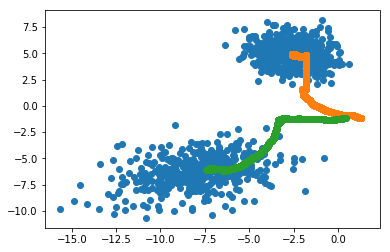

In [38]:
plt.scatter(*data.detach().numpy().T)
plt.scatter(*param_history['loc_loc_factor_0'].detach().numpy().T)
plt.scatter(*param_history['loc_loc_factor_1'].detach().numpy().T)

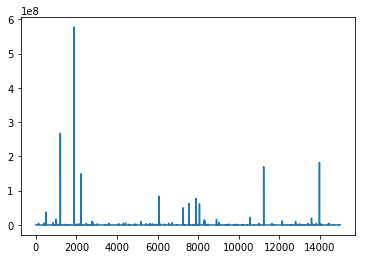

In [32]:
plt.plot(losses)

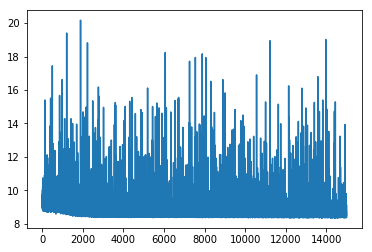

In [33]:
plt.plot(plt.log(losses))

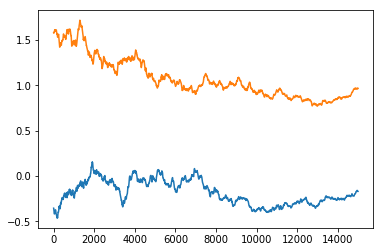

In [35]:
plt.plot(param_history['coord_scale_loc'].detach().numpy())

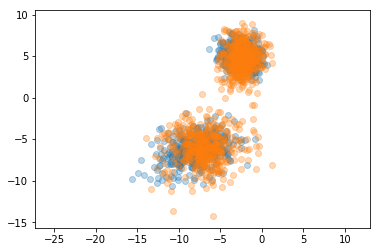

In [36]:
from tracepredictive import *

trace_pred = TracePredictive(mixtureOfFactor, svi, num_samples=1000).run(data[:,:500], hyperparameters)
random_idx = np.random.randint(1000)
predictive_dst_sample = [torch.unsqueeze(trace.nodes['obs']['value'][random_idx,:],dim=0) for trace in trace_pred.exec_traces]
predictive_dst_sample = torch.cat(predictive_dst_sample, dim=0)

plt.scatter(*data.detach().numpy().T,alpha=.3)
plt.scatter(*predictive_dst_sample.detach().numpy().T,alpha=.3);
plt.axis('equal');

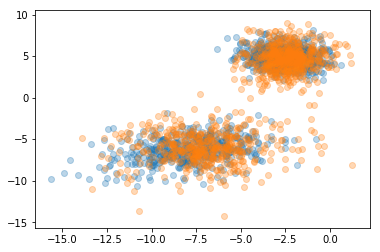

In [37]:
plt.scatter(*data.detach().numpy().T,alpha=.3)
plt.scatter(*predictive_dst_sample.detach().numpy().T,alpha=.3);
#plt.scatter(*params.get_param('loc_loc').detach().numpy().T, s=100, c='black')